TODO:



funtions for students to write:



1. box filter -> filter box based on threshold and boxes

2. iou -> calculate iou

3. nms -> write nms function but using tensorflow nms (or ask them write them self?)

4. calculate mAP mAP_r40 (optional)

5. predict -> assemble above function. input image, run yolo, box filyer, nms, box coordinate

6. mAP

6. eval -> eval mAP metrics

function provided by us:

plot_on_image -> display boxs on image



## Lab - Object Detection with CARLA Dataset

In this lab session you will be learning about implementing (part of) YOLO model and trying to detect cars from the dataset obtaining from CARLA simulator!

We have discussed many of YOLO ideas in the lecture. If you wish to learn more about it, there are the link to YOLO papers:

https://arxiv.org/abs/1506.02640

https://arxiv.org/abs/1612.08242

In the lab we won't dive into too much details about how to train a YOLO model, as its a very time consuming process and required lots computation resources.

We will be using a pretrained model from YOLO official website for our experiment.

The dataset we will be using to evaluating the model is collecting from CARLA simulator. Collected by Jean-Emmanuel Deschaud

https://arxiv.org/abs/2109.00892

CARLA simulator is an open-source simulator for autonomous driving research and its excellent playground if you wish play around with autonomous driving.

You could find more about CARLA simulator here.

https://carla.org/

**In this lab you will be learning about**:

- Implementing function for filtering bounding boxes based on scores

- Implementing function for calculating intersection over union

- Implementing function for non-max suppression to improve accuracy

- Implementing mAP metrics for evaluating our model

- Detect objects in CARLA dataset

- Evaluating our detections with grounds truth


## Import Packages

First, let we start with importing necessary packages

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

## 1 - YOLO Model Details

Before we start, let us briefly learn about how YOLO model works in detail. 

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. 

After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### Model Details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers.

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).


#### Encoding
Let's look in greater detail at what this encoding represents.
<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 1 </u></b>: Encoding architecture for YOLO<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since you're using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, you'll flatten the last two dimensions of the shape (19, 19, 5, 85) encoding, so the output of the Deep CNN is (19, 19, 425).

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: Flattening the last two last dimensions<br> </center></caption>

#### Class score

Now, for each box (of each cell) you'll compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 3</u></b>: Find the class detected by each box<br> </center></caption>

##### Example of figure 3
* In figure 3, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say you calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So you'll assign the score 0.44 and class "3" to this box "1".

#### Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:

- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u><b>Figure 4</u></b>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 

#### Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u><b>Figure 5</u></b>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, the only boxes plotted are ones for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.

## 2 - Filtering bounding boxes

Let us start with filtering out some bounding boxes based on predicted score. 

Write a function to get rid of any box while the class "scores" is less than a chosen threshold.

**Exercise**: Implement yolo_filter_boxes() function

1. Compute box scores by doing the elementwise prodcu as descirebed in Figure 3 ($p \times c$).
The following code may help you choose the right operator: 
```python
a = np.random.randn(19, 19, 5, 1)
b = np.random.randn(19, 19, 5, 80)
c = a * b # shape of c will be (19, 19, 5, 80)
```
This is an example of **broadcasting** (multiplying vectors of different sizes).


2. For each box, find:
    - the index of the class with the maximum box score
    - the corresponding box score
    - For the `axis` parameter of [tf.math.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax) and [tf.math.reduce_max](https://www.tensorflow.org/api_docs/python/tf/math/reduce_max), if you want to select the **last** axis, one way to do so is to set `axis=-1`.  This is similar to Python array indexing, where you can select the last position of an array using `arrayname[-1]`.
    - Applying [tf.math.reduce_max](https://www.tensorflow.org/api_docs/python/tf/math/reduce_max) normally collapses the axis for which the maximum is applied.  `keepdims=False` is the default option, and allows that dimension to be removed.  You don't need to keep the last dimension after applying the maximum here.

3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be `True` for the boxes you want to keep. 

4. Use TensorFlow to apply the mask to `box_class_scores`, `boxes` and `box_classes` to filter out the boxes you don't want. You should be left with just the subset of boxes you want to keep.
    - [tf.boolean mask](https://www.tensorflow.org/api_docs/python/tf/boolean_mask)
    - For the `tf.boolean_mask`, you can keep the default `axis=None`.

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    x = 10
    y = tf.constant(100)

    # YOUR CODE STARTS HERE

    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = box_class_probs * box_confidence

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)

    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold)

    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    # YOUR CODE ENDS HERE

    return scores, boxes, classes

In [3]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed=1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed=1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed=1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

assert type(scores) == EagerTensor, "Use tensorflow functions"
assert type(boxes) == EagerTensor, "Use tensorflow functions"
assert type(classes) == EagerTensor, "Use tensorflow functions"

assert scores.shape == (1789,), "Wrong shape in scores"
assert boxes.shape == (1789, 4), "Wrong shape in boxes"
assert classes.shape == (1789,), "Wrong shape in classes"

assert np.isclose(scores[2].numpy(), 9.270486), "Values are wrong on scores"
assert np.allclose(boxes[2].numpy(), [4.6399336, 3.2303846, 4.431282, -2.202031]), "Values are wrong on boxes"
assert classes[2].numpy() == 8, "Values are wrong on classes"

print("\033[92m All tests passed!")

scores[2] = 9.270486
boxes[2] = [ 4.639934   3.2303846  4.431282  -2.2020311]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)
 All tests passed!


**Expected Output**:

```
scores[2] = 9.270486
boxes[2] = [ 4.639934   3.2303846  4.431282  -2.2020311]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)
```

## 3 - Intersection over Union (IoU) calculation

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

Before we start implement non-max suppression, we need a function to calculate intersection over union.

Write a function calculate intersection over union

**Exercise**: Implement iou() function
For this exercise, a box is defined using its two corners: upper left $(x_1, y_1)$ and lower right $(x_2,y_2)$, instead of using the midpoint, height and width. This makes it a bit easier to calculate the intersection.
1. Find the coordinates of the intersection of two boxes.
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
2. Calculate intersection area
    - The two boxes **may have no intersection**.  You can detect this if the intersection coordinates you calculate end up being the top right and/or bottom left corners of an intersection box.  Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero.  This happens when either the height or width (or both) of the calculated intersection is zero.
    - For calculate intersection area, you can use `max(height, 0)` and `max(width, 0)`
3. Calculate union area
4. Calculate iou using intersection area / union area

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 8</b> </u>: Definition of "Intersection over Union". <br> </center></caption>

In [4]:
def iou(box1, box2):
    """
    Implement the intersection over union (IoU) between box1 and box2
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    # YOUR CODE STARTS HERE

    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ##(≈ 7 lines)
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = max(0, yi2 - yi1)
    inter_height = max(0, xi2 - xi1)
    inter_area = inter_width * inter_height

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ## (≈ 3 lines)
    box1_area = (box1_x2 - box1_x1) * ((box1_y2 - box1_y1))
    box2_area = (box2_x2 - box2_x1) * ((box2_y2 - box2_y1))
    union_area = box1_area + box2_area - inter_area

    # compute the IoU
    ## (≈ 1 line)
    iou = inter_area / union_area

    # YOUR CODE ENDS HERE

    return iou

In [5]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)

print("iou for intersecting boxes = " + str(iou(box1, box2)))
assert iou(box1, box2) < 1, "The intersection area must be always smaller or equal than the union area."
assert np.isclose(iou(box1, box2), 0.14285714), "Wrong value. Check your implementation. Problem with intersecting boxes"

## Test case 2: boxes do not intersect
box1 = (1, 2, 3, 4)
box2 = (5, 6, 7, 8)
print("iou for non-intersecting boxes = " + str(iou(box1, box2)))
assert iou(box1, box2) == 0, "Intersection must be 0"

## Test case 3: boxes intersect at vertices only
box1 = (1, 1, 2, 2)
box2 = (2, 2, 3, 3)
print("iou for boxes that only touch at vertices = " + str(iou(box1, box2)))
assert iou(box1, box2) == 0, "Intersection at vertices must be 0"

## Test case 4: boxes intersect at edge only
box1 = (1, 1, 3, 3)
box2 = (2, 3, 3, 4)
print("iou for boxes that only touch at edges = " + str(iou(box1, box2)))
assert iou(box1, box2) == 0, "Intersection at edges must be 0"

print("\033[92m All tests passed!")



iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
 All tests passed!


**Expected Output**:

```
iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
```

## 4 - Non-max Suppression

We are now ready to implement non-max suppression.

**Exercise**: Implement yolo_non_max_suppression() function
1. Compute the overlap between bounding boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
    - TensorFlow has built-in function that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation): [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
    - Notice that this function returns you the indices of selected boxes
2. Select bounding box based on indices you get from [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
    - [tf.gather()](https://www.tensorflow.org/api_docs/python/tf/gather) could help you select elements from array.

In [19]:
def yolo_non_max_suppression(scores, boxes, classes, max_num_boxes=10, iou_threshold=0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_num_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    # YOUR CODE STARTS HERE
    
    max_num_boxes_tensor = tf.Variable(max_num_boxes, dtype='int32')  # tensor to be used in tf.image.non_max_suppression()

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_num_boxes_tensor, iou_threshold)

    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)

    # YOUR CODE ENDS HERE

    return scores, boxes, classes

In [20]:
tf.random.set_seed(10)
scores = tf.random.normal([54, ], mean=1, stddev=4, seed=1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed=1)
classes = tf.random.normal([54, ], mean=1, stddev=4, seed=1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

assert type(scores) == EagerTensor, "Use tensoflow functions"
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"

assert np.isclose(scores[2].numpy(), 8.147684), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [6.0797963, 3.743308, 1.3914018, -0.34089637]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 1.7079165), "Wrong value on classes"

print("\033[92m All tests passed!")


scores[2] = 8.147684
boxes[2] = [ 6.0797963   3.7433083   1.3914018  -0.34089637]
classes[2] = 1.7079165
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


**Expected Output**:

```
scores[2] = 8.147684
boxes[2] = [ 6.0797963   3.7433083   1.3914018  -0.34089637]
classes[2] = 1.7079165
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
```

## 5 - Warpping Up 

Its now the time to warpping up all the functions we written already in to one single function for processing the output from neural network!

**Exercise**: Implement yolo_eval() function
1. Convert the bounding boxes output from neural network (box_xy and box_wh) to corner coordinates.
    - Here we provieded you the function yolo_boxes_to_corners() for doing that. This function simplely converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2), to fit the input of `yolo_filter_boxes`
2. Use yolo_filter_boxes() function you've implemented to perform Score-filtering.
3. Scale bounding boxes back to original image shape.
    - The reason why we needs to scale the bounding boxes is because YOLO was trained to run on 608x608 images. If you are testing this data on a different size image -- for example, the car detection dataset had 720x1280 images -- this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  
4. Use yolo_non_max_suppression() function you've implemented to perform Non-max suppression.

In [8]:
def yolo_eval(yolo_outputs, image_shape=(720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    # YOUR CODE STARTS HERE

    # Retrieve outputs of the YOLO mode
    ##(≈ 1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    ##(≈ 1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)

    # Scale boxes back to original image shape (720, 1280 or whatever)
    boxes = scale_boxes(boxes, image_shape)  # Network was trained to run on 608x608 images

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold
    ##(≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    # YOUR CODE ENDS HERE

    return scores, boxes, classes

In [9]:
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed=1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed=1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed=1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed=1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"

assert np.isclose(scores[2].numpy(), 171.60194), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [-1240.3483, -3212.5881, -645.78, 2024.3052]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 16), "Wrong value on classes"

print("\033[92m All tests passed!")

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


**Expected Output**:

```
scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
```

## 6 - Run Pre-trained YOLO Model on CARLA dataset 

Now we are ready to process the YOLO model output. Time to test it with our CARLA dataset.

**Exercise**: Implement predict() function
1. Load the pretrained model using [tf.keras.models.load_model()](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model). Set `compile` to False.
2. Load and preprocess our images in the path "images/", remember resize our image to size (608,608).
3. Feed our images into loaded YOLO model
4. Postprocess YOLO model output using yolo_eval()

In [10]:
# Load necessary information from txt. Since YOLO model are able to detect 80 classes and using 5 anchor boxes.
# The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". 
# You'll read class names and anchors from text files.
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608)  # Same as yolo_model input layer size

In [11]:
# Load the pretrained model. The path of pretrained H5HD file is: "./model_data/yolo.h5"
# Remember to set compile=False
##(≈1 line)
yolo_model = load_model("model_data/yolo.h5", compile=False)

In [12]:
# Here's a summary of the layers your model contains:
yolo_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    # YOUR CODE STARTS HERE

    # Preprocess images
    image, image_data = preprocess_image("images/" + image_file, model_image_size=model_image_size)
    
    # Feed the image_data into yolo_model. Simply by calling the model as function
    ##(≈1 line)
    yolo_model_outputs = yolo_model(image_data)  # It's output is of shape (m, 19, 19, 5, 85)
    
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    # Feed yolo_outpus into yolo_eval function. 
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1], image.size[0]], 10, 0.3, 0.5)
    
    # YOUR CODE ENDS HERE
    
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", str(image_file).split('.')[0] + "_annotated." + str(image_file).split('.')[1]), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", str(image_file).split('.')[0] + "_annotated." + str(image_file).split('.')[1]))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test1.jpg
car 0.83 (302, 510) (516, 648)
car 0.81 (830, 530) (977, 636)
car 0.78 (35, 526) (300, 647)
car 0.71 (579, 540) (747, 653)
traffic light 0.71 (832, 165) (867, 241)
car 0.64 (756, 516) (839, 578)
traffic light 0.62 (426, 167) (458, 244)
traffic light 0.62 (917, 300) (943, 341)
traffic light 0.58 (615, 165) (646, 239)
car 0.53 (515, 516) (569, 573)


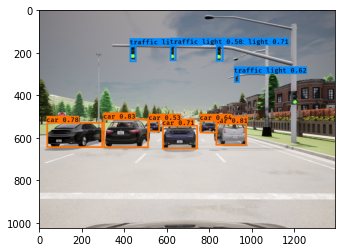

In [14]:
out_scores, out_boxes, out_classes = predict("test1.jpg")

**Expected Output**:

```
Found 10 boxes for images/test1.jpg
car 0.83 (302, 510) (516, 648)
car 0.81 (830, 530) (977, 636)
car 0.78 (35, 526) (300, 647)
car 0.71 (579, 540) (747, 653)
traffic light 0.71 (832, 165) (867, 241)
car 0.64 (756, 516) (839, 578)
traffic light 0.62 (426, 167) (458, 244)
traffic light 0.62 (917, 300) (943, 341)
traffic light 0.58 (615, 165) (646, 239)
car 0.53 (515, 516) (569, 573)
```

## 7 - Average Precision (AP) Calculation

Now we able to obtain results from YOLO model. We could now use some metrics to evaluate YOLO model.

**Exercise**: Implement mean_average_precision() function

In [15]:
import sklearn.metrics

def precision_recall_curve(y_true, pred_scores, thresholds):
    precisions = []
    recalls = []

    for threshold in thresholds:
        y_pred = ["positive" if score >= threshold else "negative" for score in pred_scores]

        precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")

        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

In [16]:
y_true = ["positive", "negative", "negative", "positive", "positive", "positive", "negative", "positive", "negative", "positive", "positive", "positive", "positive", "negative", "negative", "negative"]
pred_scores = [0.7, 0.3, 0.5, 0.6, 0.55, 0.9, 0.4, 0.2, 0.4, 0.3, 0.7, 0.5, 0.8, 0.2, 0.3, 0.35]
thresholds=np.arange(start=0.2, stop=0.7, step=0.05)

precisions, recalls = precision_recall_curve(y_true=y_true,
                                             pred_scores=pred_scores,
                                             thresholds=thresholds)

precisions.append(1)
recalls.append(0)

precisions = np.array(precisions)
recalls = np.array(recalls)

AP = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
print(AP)

0.8898809523809523


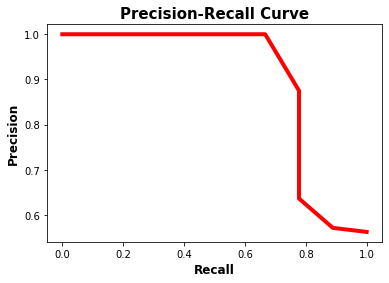

In [17]:
plt.plot(recalls, precisions, linewidth=4, color="red")
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precision", fontsize=12, fontweight='bold')
plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
plt.show()

In [18]:
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold

    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image.
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image.
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output:
        map: mean average precision of the image
    """

    # According to the introduction, images with no ground truth bboxes will not be
    # included in the map score unless there is a false positive detection (?)

    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None

    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]

    map_total = 0

    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN

        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m

    return map_total / len(thresholds)

## References:

Andrew Ng, Kian Katanforoosh, Younes Bensouda Mourri - [Coursera - Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks#instructors)
Steven Waslander, Jonathan Kelly - [Coursera - Visual Perception for Self-Driving Cars](https://www.coursera.org/learn/visual-perception-self-driving-cars?specialization=self-driving-cars)
Allan Zelener - [Github - YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
Joseph Redmon - [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/)
Jean-Emmanuel Deschaud - [KITTI-CARLA: a KITTI-like dataset generated by CARLA Simulator](https://npm3d.fr/kitti-carla)
Abdur Rahman - [Github - Deep Learning Specialization Coursera](https://github.com/abdur75648/Deep-Learning-Specialization-Coursera)